<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
import re
import time
import random
import numpy as np
import scipy as sp
import pickle
import hashlib
import math
import shutil
import PIL
import cv2
import pandas as pd
import warnings

from tqdm import tqdm 

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from mpl_toolkits.axes_grid1 import ImageGrid

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image, display

np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [2]:
#%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.5.0
Eager mode: True
Found GPU at: /device:GPU:0


In [3]:
def safe_divide(a, b, abs=True):
  val = 0 if type(a) is not np.ndarray else np.zeros(a.shape)

  if b != 0 and not math.isnan(b):
    val = np.divide(a, b)

  return np.int0(val) if abs else val

In [4]:
def resize_image(image, size):
  if len(image.shape) > 2:
    image = image.reshape(size[0], size[1])

  if image.shape[0] != size[0] or image.shape[1] != size[1]:
    width_zoom = size[0] / image.shape[0]
    height_zoom = size[1] / image.shape[1]
    image = sp.ndimage.zoom(image, (height_zoom, width_zoom), order=2)

  return image

In [5]:
def show_image(img, size=None, title=None, ax=None, alpha=1, cmap='Greys', rotation=0, stacked_imgs=[]):
  if size is not None:
    img = resize_image(img, size)
    # img.reshape(size[0], size[1])

  # plot
  subplot = ax is not None

  if not subplot:
    plt.figure(facecolor='white')
    ax = plt.gca()

  ax.set_xticklabels([])
  ax.set_yticklabels([])

  if rotation != 0:
    img = scipy.ndimage.rotate(img, rotation)
  
  if not subplot:
    plt.imshow(img, cmap=cmap, alpha=alpha)
    for s_image in stacked_imgs:
      s_img = s_image.get('img').reshape(size[0], size[1])
      if rotation != 0:
        s_img = scipy.ndimage.rotate(s_img, rotation)
      plt.imshow(s_img, cmap=s_image.get('cmap') or 'Greys', alpha=s_image.get('alpha') or 0.5)

    plt.axis('off')

    if title is not None:
      plt.title(title)
    
    plt.show()
  
  else:
    if title is not None:
      ax.set_title(title, fontdict=None, loc='center', color = "k")

    ax.imshow(img, cmap=cmap, alpha=alpha)
    for s_image in stacked_imgs:
        s_img = s_image.get('img').reshape(size[0], size[1])
        if rotation != 0:
          s_img = scipy.ndimage.rotate(s_img, rotation)
        ax.imshow(s_img, cmap=s_image.get('cmap') or 'Greys', alpha=s_image.get('alpha') or 0.5)

In [6]:
def show_heatmap(img, cam, size, resize=True, title=None, ax=None):
  heatmap = get_heatmap(cam, size, resize)
  show_image(img, size, title=title, ax=ax, alpha=0.3, stacked_imgs=[{'img':heatmap, 'cmap':'jet'}])

In [7]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    heatmap = resize_image(heatmap, size)
 
  return heatmap

In [8]:
def show_prediction(image, truth, prediction, label_descriptions=None, size=(28,28)):
  prediction = np.argmax(prediction)
  prediction = prediction if label_descriptions is None else label_descriptions[prediction]
  truth = truth if label_descriptions is None else label_descriptions[truth]
  title = f"Prediction: {prediction} / Truth: {truth}"
  show_image(image, size, title)

In [9]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [10]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [11]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [12]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [13]:
def get_layer(model, layer_name):
  for layer in model.layers:
    if layer.name == layer_name:
      return layer

  return None

In [14]:
def get_sample(test_set, idx=-1):
  test_idx = random.randint(0, len(test_set[0])) if idx < 0 else idx
  test_image = test_set[0][test_idx]
  test_label = np.argmax(test_set[1][test_idx])

  return test_image, test_label, test_idx

In [15]:
def predict(model, image):
  return model.predict(np.expand_dims(image, 0))

In [16]:
def get_prediction(model, test_set, idx=-1):
  x, y, idx = get_sample(test_set, idx)
  prediction = predict(model, x)

  return x, y, prediction, idx

In [17]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

In [18]:
def copy_model(original_model, trainable=False):
  new_model = keras.models.clone_model(original_model)
  new_model.set_weights(original_model.get_weights())
  new_model.trainable = trainable
  return new_model

In [19]:
def get_boundingbox(image):
  img = np.ones(3, dtype=int)[None, None, :] * (1-image)
  imgray = cv2.cvtColor(img.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(imgray, 127, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  return cv2.boundingRect(contours[-1])

In [20]:
def get_grid_position(position, size, boundingbox=None, divisions=(3,3)):
  min_x = 0 if boundingbox is None else boundingbox[0]
  min_y = 0 if boundingbox is None else boundingbox[1]
  max_x = size[0] if boundingbox is None else boundingbox[0] + boundingbox[2]
  max_y = size[1] if boundingbox is None else boundingbox[1] + boundingbox[3]
  x = np.clip(position[0], min_x, max_x) - min_x
  y = np.clip(position[1], min_y, max_y) - min_y

  horizontal_idx =  np.minimum(x / (max_x / divisions[0]), divisions[0]-1)
  vertical_idx =  np.minimum(y / (max_y / divisions[1]), divisions[1]-1)

  # print(f"{vertical_idx}, {horizontal_idx} => {position} - {x}, {y} [{boundingbox}]")
  return np.int0(horizontal_idx), np.int0(vertical_idx)

In [21]:
def get_verbose_grid_position(horizontal_idx, vertical_idx):
  horizontal_labels = ['left', 'mid', 'right']
  vertical_labels = ['top', 'mid', 'bottom']
  
  vertical_idx = np.clip(vertical_idx, 0, len(horizontal_labels)-1)
  horizontal_idx = np.clip(horizontal_idx, 0, len(vertical_labels)-1)

  return horizontal_labels[horizontal_idx], vertical_labels[vertical_idx]

In [22]:
def download_file(name, filepath):
  return tf.keras.utils.get_file(name, filepath)

In [23]:
def load_npz_dataset(path):
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [24]:
def normalize_cam(cam):
  max = np.max(cam)
  min = np.min(cam)
  norm = safe_divide(cam - min, max - min, abs=False)

  return min, max, norm

In [25]:
def show_image_in_grid(image_2d_np_array, image_size, figsize=(16, 16), padding=0.3):
  image_idx = 0
  fig = plt.figure(figsize=figsize)
  grid = ImageGrid(fig, 111, nrows_ncols=image_2d_np_array.shape[:2], axes_pad=padding, label_mode="1")

  for row in image_2d_np_array:
    for image in row:
      grid[image_idx].axis('off')
      grid[image_idx].get_yaxis().set_ticks([])
      grid[image_idx].get_xaxis().set_ticks([])
      if isinstance(image, dict):
        show_image(image['img'], image_size, ax=grid[image_idx], cmap=image['cmap'], title=image['title'] if 'title' in image else None)
      else:
        show_image(image, image_size, ax=grid[image_idx])
      image_idx += 1

  plt.axis('off')
  plt.show()

# CAMs

In [26]:
def cam(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[0][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

In [27]:
def grad_cam_m(image, cam_model, prediction_idx=-1, prediction_output=0):
  with tf.GradientTape() as tape:
    func_return = cam_model(np.expand_dims(image, 0))
    conv_output, predictions = func_return[prediction_output] if len(func_return[0]) > 1 else func_return
    predictions = predictions[prediction_output] if len(predictions) > 1 else predictions
    prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
    output = predictions[:, prediction_idx]

  grads = tape.gradient(output, conv_output)
  # print(f"{prediction_idx} -> {hashlib.sha256(grads).hexdigest().upper()}")
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  conv_output = conv_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()

  for i in range(pooled_grads.shape[-1]):
    conv_output[:, :, i] *= pooled_grads[i]

  cam = np.mean(conv_output, axis=-1)

  return cam, conv_output, predictions, pooled_grads

def grad_cam(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_m(image, cam_model, prediction_idx)

In [28]:
def grad_cam_pp_m(image, cam_model, prediction_idx=-1, prediction_output=0):
  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
            func_return = cam_model(np.expand_dims(image, 0))
            conv_output, predictions = func_return[prediction_output] if len(func_return[0]) > 1 else func_return
            predictions = predictions[prediction_output] if len(predictions) > 1 else predictions
            prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
            output = predictions[:, prediction_idx]
            conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, predictions, (conv_first_grad, conv_second_grad, conv_third_grad)

def grad_cam_pp(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_pp_m(image, cam_model, prediction_idx)

#MNIST

In [29]:
mnist_num_classes = 10
mnist_shape = (28, 28)
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(mnist_num_classes, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          # V1
          # layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="mnist_first_conv"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          # layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          # layers.Dropout(0.5),
          # layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", name="mnist_last_conv"),
       
          # V3
          # layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_first_conv"),
          # layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          # layers.Dropout(0.4),
       
          # V2
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_last_conv"),
       
          # second part
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="mnist_output"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

11493376/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


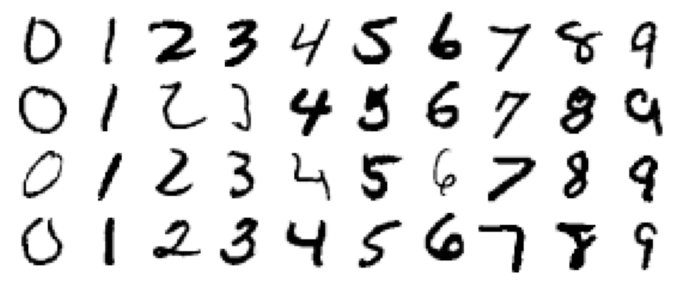

In [30]:
img_list = []
for i in range(4):
  img_list.append([])
  for j in range(mnist_num_classes):
    decomposed_category = np.zeros(shape=(mnist_num_classes))
    decomposed_category[j] = 1
    idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))
    x, y, idx = get_sample(mnist_test, idx)
    img_list[i].append(x)

show_image_in_grid(np.asarray(img_list), mnist_shape, figsize=(12, 12), padding=0)

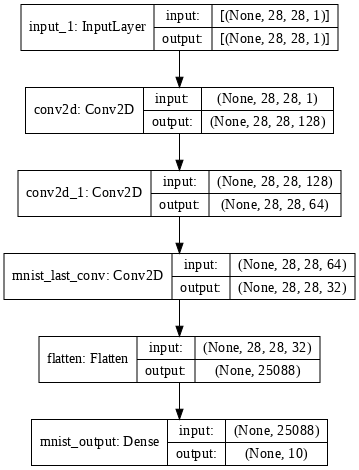

Epoch 1/5
375/375 [==============================] - 39s 21ms/step - loss: 0.1833 - accuracy: 0.9457 - val_loss: 0.0747 - val_accuracy: 0.9790
Epoch 2/5
375/375 [==============================] - 7s 20ms/step - loss: 0.0516 - accuracy: 0.9843 - val_loss: 0.0554 - val_accuracy: 0.9842
Epoch 3/5
375/375 [==============================] - 7s 20ms/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.0497 - val_accuracy: 0.9847
Epoch 4/5
375/375 [==============================] - 8s 20ms/step - loss: 0.0247 - accuracy: 0.9918 - val_loss: 0.0492 - val_accuracy: 0.9867
Epoch 5/5
375/375 [==============================] - 8s 22ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0651 - val_accuracy: 0.9842
Training took: 70.27 seconds


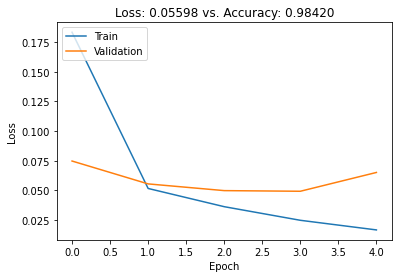

In [31]:
model_mnist = create_mnist_model("gap_shallow", (*mnist_shape, 1), mnist_num_classes, mnist_train)
# model_mnist, history_mnist = load_model("gap_shallow")

display(keras.utils.plot_model(model_mnist, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=5, validation_split=0.2)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_mnist, history_mnist, "gap_shallow")

# evaluate
score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_mnist, history_mnist.history)

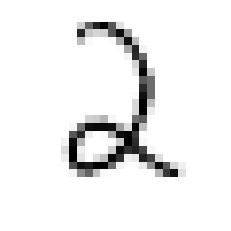

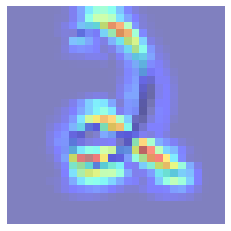

In [32]:
image, truth, prediction, _ = get_prediction(model_mnist, mnist_test)
cam, _, _, _ = grad_cam(image, model_mnist)

show_image(image, mnist_shape)
show_heatmap(image, cam, mnist_shape)

#FACE

In [33]:
# https://storage.googleapis.com/public_release/FEC_dataset.zip

fer_dataset = ("fer2013.tar.gz", "https://geo-cam.s3-eu-west-1.amazonaws.com/fer2013.tar.gz", ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
# fer_dataset_path = download_file(fer_dataset[0], fer_dataset[1])
# fer_dataset_explodede_root = f"{fer_dataset[0]}_exploded"
# fer_dataset_explodede_path = f"{fer_dataset_explodede_root}/fer2013/fer2013.csv"

# shutil.unpack_archive(fer_dataset_path, fer_dataset_explodede_root)

In [34]:
# df = pd.read_csv(fer_dataset_explodede_path)
# print(df.shape) 

#GEO

In [35]:
geo_dataset_proto = ("proto", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz", ["vertical line", "45° oriented line", "ellipse"])
geo_dataset_simple = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset2_dataset.npz", ["vertical line", "horizontal line", "45° oriented line", "ellipse", "greater-than sign", "lower-than sign"])
geo_dataset_simple3 = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset3_dataset.npz", ["vertical line", "horizontal line", "45° oriented line", "135° oriented line", "ellipse", "greater-than sign", "lower-than sign", "arrow-up sign", "arrow-down sign"])
geo_dataset_round = ("round", "https://geo-cam.s3-eu-west-1.amazonaws.com/rounddataset_dataset.npz", ["vertical line", "horizontal line", "45° oriented line", "ellipse", "greater-than sign", "lower-than sign"])
geo_dataset_threesixty = ("threesixty", "https://geo-cam.s3-eu-west-1.amazonaws.com/threesixtydataset_dataset.npz", ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150", "160", "170", "180"])

# dataset
dataset = geo_dataset_simple3
dataset_labels = dataset[2]
dataset_path = download_file(dataset[0], dataset[1])
geo_train, geo_test = load_npz_dataset(dataset_path)
geo_train, geo_test = format_dataset(len(dataset_labels), geo_train, geo_test)

28262400/28261002 [==============================] - 2s 0us/step
(28, 28)
2
x_train shape: (6300, 28, 28, 1)
6300 train samples
2700 test samples


In [36]:
def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="geo_first_conv"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.4),
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="geo_last_conv"),
          # layers.GlobalAveragePooling2D(),
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="geo_output"),
      ]
  )

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

  return model

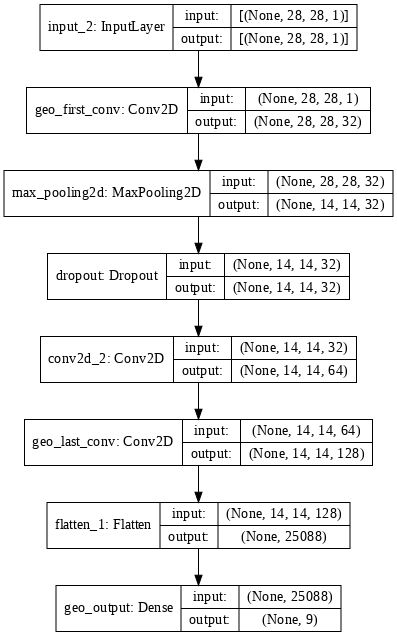

Epoch 1/5
37/37 [==============================] - 1s 21ms/step - loss: 1.5853 - accuracy: 0.4550 - val_loss: 0.8631 - val_accuracy: 0.7606
Epoch 2/5
37/37 [==============================] - 0s 10ms/step - loss: 0.4006 - accuracy: 0.8849 - val_loss: 0.1849 - val_accuracy: 0.9397
Epoch 3/5
37/37 [==============================] - 0s 10ms/step - loss: 0.1010 - accuracy: 0.9727 - val_loss: 0.1086 - val_accuracy: 0.9670
Epoch 4/5
37/37 [==============================] - 0s 10ms/step - loss: 0.0440 - accuracy: 0.9877 - val_loss: 0.0634 - val_accuracy: 0.9790
Epoch 5/5
37/37 [==============================] - 0s 10ms/step - loss: 0.0199 - accuracy: 0.9947 - val_loss: 0.0386 - val_accuracy: 0.9879
Training took: 3.00 seconds


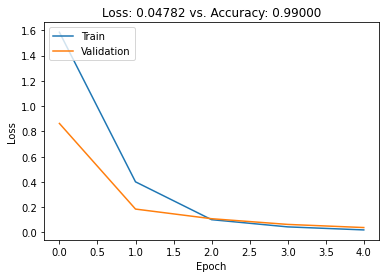

In [37]:
# model
model_geo = create_geo_model("geocam", (*mnist_shape, 1), len(dataset_labels))
# model_geo, history_geo = load_model("geo")

display(keras.utils.plot_model(model_geo, show_shapes=True, dpi=72))

start_time = time.perf_counter()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=5, validation_split=0.25)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_geo, history_geo, "geo")

score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)
plot_model_score(score_geo, history_geo.history)

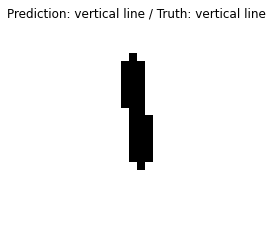

In [38]:
image, truth, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, truth, prediction, dataset_labels)

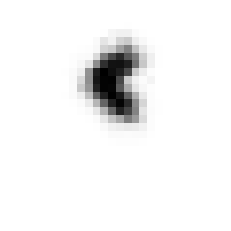

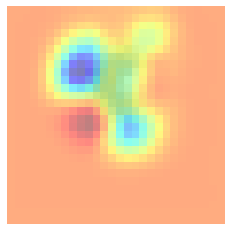

In [39]:
image, truth, prediction, _ = get_prediction(model_geo, geo_test)
cam, _, _, _ = grad_cam(image, model_geo)

show_image(image, mnist_shape)
show_heatmap(image, cam, mnist_shape)

# Transfer-learning


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
geo_first_conv (Conv2D)         (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           geo_first_conv[1][0]             
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 14, 32)   0           max_pooling2d[1][0]              
____________________________________________________________________________________________

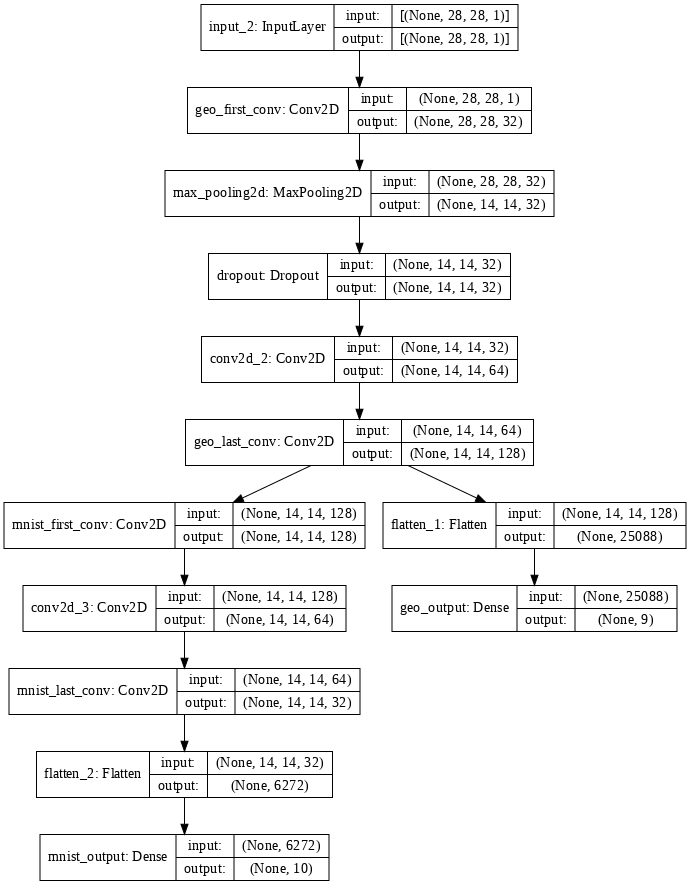

Epoch 1/5
375/375 [==============================] - 5s 12ms/step - loss: 0.2028 - accuracy: 0.9390 - val_loss: 0.0943 - val_accuracy: 0.9712
Epoch 2/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0871 - accuracy: 0.9735 - val_loss: 0.0716 - val_accuracy: 0.9769
Epoch 3/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0754 - accuracy: 0.9763 - val_loss: 0.0776 - val_accuracy: 0.9760
Epoch 4/5
375/375 [==============================] - 4s 12ms/step - loss: 0.0652 - accuracy: 0.9793 - val_loss: 0.0656 - val_accuracy: 0.9809
Epoch 5/5
375/375 [==============================] - 4s 12ms/step - loss: 0.0605 - accuracy: 0.9812 - val_loss: 0.0833 - val_accuracy: 0.9758
Training took: 41.47 seconds


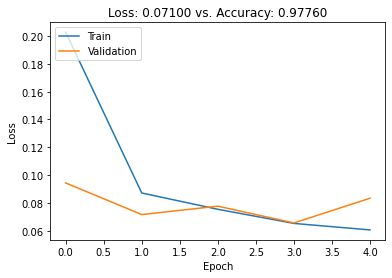

In [40]:
mnist_model_copy = copy_model(model_mnist, True)
mnist_model_layers = get_cam_layers(mnist_model_copy)
geo_model_copy = copy_model(model_geo, False)
input = geo_model_copy.input
geo_last, geo2_last, last = input, None, None

# GEO - 1
for layer in get_cam_layers(geo_model_copy)[0]:
  layer.trainable = False
  # print(f"{layer.name} - {layer.input_shape}:{layer.output_shape}")
  geo_last = layer(geo_last)

# MNIST - 1
mnist_first_cnn = last = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_first_conv")(geo_last)
last = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(last)
last = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_last_conv")(last)

# mnist_first_cnn = last = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_first_conv")(geo_last)
# last = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(last)
# last = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(last)
# last = layers.Dropout(0.4)(last)
# last = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(last)
# last = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(last)
# last = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_last_conv")(last)

# MNIST - 2
last = layers.Flatten()(last)
last = layers.Dense(mnist_num_classes, activation="softmax", name="mnist_output")(last)

# CONNECTION
connection = geo_last

# GEO - 2
for layer in get_cam_layers(geo_model_copy)[1]:
  layer.trainable = False
  geo2_last = layer(connection) if geo2_last is None else layer(geo2_last)

# MODEL
model_gcm = Model(inputs=input, outputs=last)
model_gcm_complete = Model(inputs=input, outputs=[last, geo2_last])

opt = keras.optimizers.Adam(learning_rate=0.004)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# display
print(model_gcm_complete.summary())

display(keras.utils.plot_model(model_gcm_complete, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=5, validation_split=0.2)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))

# evaluate
score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_gcm, history_geocam.history)

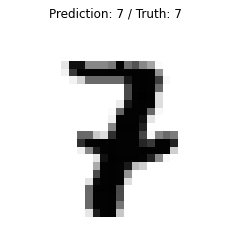

In [41]:
image, label, prediction, _ = get_prediction(model_gcm, mnist_test)
show_prediction(image, label, prediction)

# Experiments

In [126]:
def get_experiment_cam_predictions(test_image, kdn, pdn,
                                   use_mask=False,
                                   cam_method=grad_cam_m, 
                                   threshold=0.8, 
                                   shape=mnist_shape):
  centers = dict()
  grid_pos = dict()
  geo_cam = dict()
  cam_thresh = dict()

  geo_cam_maxes = []
  attenuated_geo_cam_maxes = []

  test_image_bb = get_boundingbox(test_image)

  # pd branch
  cam, _, predictions, _ = cam_method(test_image, pdn['model'], -1, pdn['output_branch'])
  _, _, cam = normalize_cam(cam)
  pd_cam = np.copy(cam)

  # kd branch
  for category in range(kdn['num_classes']):
    cam, _, _, _  = cam_method(test_image, kdn['model'], category, kdn['output_branch'])
    min, max, cam = normalize_cam(cam)

    geo_cam[category] = np.copy(cam)
    geo_cam_maxes.append(max)

  # attenuated cam
  for category in range(kdn['num_classes']):
    modulation = safe_divide(geo_cam_maxes[category], np.max(geo_cam_maxes), abs=False) # modulation
    if use_mask: # use main model as mask
      cam = geo_cam[category] - (geo_cam[category] * (1 - pd_cam))
    else:
      cam = geo_cam[category]

    cam = cam * modulation
    # print(f"min: {np.min(cam)}, max: {np.max(cam)}")
    attenuated_geo_cam_maxes.append(np.max(cam) * modulation)
    geo_cam[category] = np.copy(cam)

  # threshorld and centers
  for category in range(kdn['num_classes']):
    cam = geo_cam[category]
    cam = resize_image(cam, shape)

    cam = cv2.dilate(cam, None, iterations=3)
    _, cam = cv2.threshold(cam, np.max(cam) * threshold, np.max(cam), cv2.THRESH_BINARY)
    
    cam_thresh[category] = cam

    cv_img = np.array(np.copy(cam) * 255, dtype = np.uint8)
    contours, _ = cv2.findContours(cv_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centers[category] = []
    grid_pos[category] = set()

    for i in range(len(contours)):
      moments = cv2.moments(contours[i], True)
      if moments['m00'] > 0:
        # center = cv2.minAreaRect(contours[i])[0]
        center = (safe_divide(moments['m10'], moments['m00']), safe_divide(moments['m01'], moments['m00']))
        centers[category].append(center)
        grid_position = get_grid_position(center, shape, boundingbox=test_image_bb)
        grid_pos[category].add(grid_position)

  extra_infos = dict()
  extra_infos['order'] = np.flip(np.argsort(attenuated_geo_cam_maxes), 0)
  extra_infos['maxes'] = attenuated_geo_cam_maxes
  extra_infos['thresholds'] = cam_thresh
  extra_infos['geo_cams'] = geo_cam
  extra_infos['pd_cam'] = pd_cam
  extra_infos['predictions'] = np.argmax(predictions)
  extra_infos['centers'] = centers
  extra_infos['grid_pos'] = grid_pos

  return geo_cam, extra_infos

def get_experiment_cam_predictions_short(test_image, settings):
  return get_experiment_cam_predictions(test_image, settings['kdn'], settings['pdn'],
                                              use_mask=settings['use_mask'],
                                              cam_method=settings['cam_method'], 
                                              threshold=settings['threshold'], 
                                              shape=settings['shape'])

# Validating

In [136]:
# Functional models
model_geocam = Model([model_geo.inputs], [get_layer(model_geo, "geo_last_conv").get_output_at(0), model_geo.output])
model_mnistcam = Model([model_mnist.inputs], [get_layer(model_mnist, "mnist_last_conv").get_output_at(0), model_mnist.output])

model_gcmcam_mnist_first = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "mnist_first_conv").get_output_at(0), 
                      model_gcm_complete.output])

model_gcmcam_mnist_last = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "mnist_last_conv").get_output_at(0), 
                      model_gcm_complete.output])

model_gcmcam_geo = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "geo_last_conv").get_output_at(1), 
                      model_gcm_complete.output])

# Basic values
nr_top_prediction_considered = 2
common_threshold = 0.8
common_cam_method = grad_cam_pp_m

# Isolated KDN CAM
isolated_geo_settings = {'kdn':{'model':model_geocam, 'num_classes': len(dataset_labels), 'output_branch':0}, 
                       'pdn':{'model':model_mnistcam, 'num_classes': mnist_num_classes, 'output_branch':0},
                       'use_mask':False, 'cam_method':common_cam_method, 'threshold':common_threshold, 'shape':mnist_shape}

# Masked KDN CAM
masked_settings = {'kdn':{'model':model_gcmcam_geo, 'num_classes': len(dataset_labels), 'output_branch':1}, 
                   'pdn':{'model':model_gcmcam_mnist_last, 'num_classes': mnist_num_classes, 'output_branch':0},
                   'use_mask':True, 'cam_method':common_cam_method, 'threshold':common_threshold, 'shape':mnist_shape}

####### BEING TESTED #####
experiment_settings = masked_settings

## Evaluation Metrics


In [135]:
vertical = 0
horizontal = 1 
fwd_diagonal = 2
ellipse = 4
greather_than = 5
lower_than = 6

digits_descriptions = [
  [{'desc': dataset_labels[ellipse], 'pos':[(1, 0), (1, 1), (1, 2)]}], #0
  [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
   {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]}], #1
  [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
   {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]},
   {'desc': dataset_labels[horizontal], 'pos':[(1, 2)]}, 
   {'desc': dataset_labels[greather_than], 'pos':[(1, 0)]}], #2
  [{'desc': dataset_labels[greather_than], 'pos':[(1, 0), (1, 2)]}, 
   {'desc': dataset_labels[lower_than], 'pos':[(1, 1)]}], #3
  [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2), (0, 0), (0, 1)]}, 
   {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2), (0, 1), (0, 0)]},
   {'desc': dataset_labels[horizontal], 'pos':[(1, 1)]}], #4
  [{'desc': dataset_labels[vertical], 'pos':[(0, 1)]}, 
   {'desc': dataset_labels[greather_than], 'pos':[(2, 1), (2, 2)]},
   {'desc': dataset_labels[horizontal], 'pos':[(1, 0), (1, 1)]}], #5
  [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
   {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]},
   {'desc': dataset_labels[ellipse], 'pos':[(1, 1), (1, 2)]}], #6
  [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
   {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]},
   {'desc': dataset_labels[horizontal], 'pos':[(0, 0), (1, 0), (2, 0)]}], #7
  [{'desc': dataset_labels[ellipse], 'pos':[(1, 0), (1, 2)]}], #8
  [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
   {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]},
   {'desc': dataset_labels[ellipse], 'pos':[(1, 0), (1, 1)]}], #9
]

samples = 20
min_prediction_value = 0
localization_check_enabled = True

metrics, y_true, y_pred = dict(), dict(), dict()
with tqdm(total=(samples * mnist_num_classes), position=0, leave=True) as pbar:
  for mnist_category in range(mnist_num_classes):
    metrics[mnist_category] = dict()
    
    decomposed_category = np.zeros(shape=(mnist_num_classes))
    decomposed_category[mnist_category] = 1
    
    y_true[mnist_category] = np.ones(shape=(samples))
    y_pred[mnist_category] = np.zeros(shape=(samples))

    for i in range(samples):
      validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]
      test_image = mnist_test[0][validation_idx]

      # geo cam
      cam, extras = get_experiment_cam_predictions_short(test_image, experiment_settings)

      # prediction
      for p in range(nr_top_prediction_considered):
        geo_id = extras['order'][p]
        if y_pred[mnist_category][i] == 1 or extras['maxes'][geo_id] < min_prediction_value:
          continue
        
        results = list(filter(lambda description: description['desc'] == dataset_labels[geo_id], digits_descriptions[mnist_category]))
        
        if localization_check_enabled:
          for r in results:
            possible_positions = r['pos']
            positions_found = extras['grid_pos'][geo_id]
            matches = len(set(positions_found) & set(positions_found)) > 0
            if matches:
              y_pred[mnist_category][i] = 1
              break
        else:
          y_pred[mnist_category][i] = 1

      pbar.update()

    # metrics per category
    metrics[mnist_category]['accuracy']   = accuracy_score(y_true[mnist_category], y_pred[mnist_category])
    metrics[mnist_category]['precision']  = precision_score(y_true[mnist_category], y_pred[mnist_category], average='weighted', zero_division=0)
    metrics[mnist_category]['recall']     = recall_score(y_true[mnist_category], y_pred[mnist_category], average='weighted', zero_division=0)
    metrics[mnist_category]['f1']         = f1_score(y_true[mnist_category], y_pred[mnist_category], average='weighted', zero_division=0)

# out
print("\n\nMETRICS:")

# macro metrics
print("\nMacro:")
macro_metrics = dict()
for cat in metrics:
  for key in metrics[cat]:
    macro_metrics[key] = macro_metrics.get(key) or []
    macro_metrics[key].append(metrics[cat][key])
  
for key in macro_metrics:
  print(f"- {key}: {np.average(macro_metrics[key]):.2f}")

# micro metrics
print("\nMicro:")
for cat in metrics:
  all_metrics = ', '.join([f"{key}:{np.average(metrics[cat][key]):.2f}" for key in metrics[cat]])
  print(f"- {cat}: {all_metrics}")

100%|██████████| 200/200 [00:33<00:00,  5.96it/s]



METRICS:

Macro:
- accuracy: 0.67
- precision: 1.00
- recall: 0.67
- f1: 0.76

Micro:
- 0: accuracy:0.70, precision:1.00, recall:0.70, f1:0.82
- 1: accuracy:0.20, precision:1.00, recall:0.20, f1:0.33
- 2: accuracy:0.70, precision:1.00, recall:0.70, f1:0.82
- 3: accuracy:0.60, precision:1.00, recall:0.60, f1:0.75
- 4: accuracy:0.85, precision:1.00, recall:0.85, f1:0.92
- 5: accuracy:0.15, precision:1.00, recall:0.15, f1:0.26
- 6: accuracy:1.00, precision:1.00, recall:1.00, f1:1.00
- 7: accuracy:0.60, precision:1.00, recall:0.60, f1:0.75
- 8: accuracy:0.90, precision:1.00, recall:0.90, f1:0.95
- 9: accuracy:1.00, precision:1.00, recall:1.00, f1:1.00


In [109]:
raise Exception('do not run any further')

Exception: ignored

## Validation Average

In [137]:
samples = 20
descriptions = dict()

with tqdm(total=(samples * mnist_num_classes), position=0, leave=True) as pbar:
  for mnist_category in range(mnist_num_classes):
      descriptions[mnist_category] = dict()
      decomposed_category = np.zeros(shape=(mnist_num_classes))
      decomposed_category[mnist_category] = 1

      for geo_class in range(len(dataset_labels)):
          descriptions[mnist_category][geo_class] = []

      for i in range(samples):
        validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]
        test_image = mnist_test[0][validation_idx]
        test_image_bb = get_boundingbox(test_image)

        # geo cam
        cam, extras = get_experiment_cam_predictions_short(test_image, experiment_settings)

        for i in range(nr_top_prediction_considered):
          geo_category_key = extras['order'][i]

          for grid_position in extras['grid_pos'][geo_category_key]:
            descriptions[mnist_category][geo_category_key].append(grid_position)

        pbar.update()

100%|██████████| 200/200 [00:38<00:00,  5.15it/s]


### Category Description

In [138]:
for category in range(mnist_num_classes):
  print(f"\n{category}")

  for description_position in descriptions[category]:
    verbose_positions = set()
    grid_position = descriptions[category][description_position]
    aggregated_amount = len(grid_position)
    
    for k in grid_position:
      verbose_positions.add(get_verbose_grid_position(*k))
    
    print(f"└ {dataset_labels[description_position]}: {aggregated_amount} = {verbose_positions}")


0
└ vertical line: 0 = set()
└ horizontal line: 0 = set()
└ 45° oriented line: 12 = {('right', 'top'), ('left', 'mid'), ('mid', 'top'), ('mid', 'mid'), ('left', 'top')}
└ 135° oriented line: 0 = set()
└ ellipse: 15 = {('right', 'top'), ('left', 'mid'), ('mid', 'top'), ('mid', 'mid'), ('left', 'top')}
└ greater-than sign: 1 = {('mid', 'top')}
└ lower-than sign: 0 = set()
└ arrow-up sign: 2 = {('mid', 'top'), ('left', 'top')}
└ arrow-down sign: 0 = set()

1
└ vertical line: 10 = {('left', 'bottom'), ('left', 'mid'), ('mid', 'top'), ('mid', 'mid'), ('left', 'top')}
└ horizontal line: 0 = set()
└ 45° oriented line: 6 = {('left', 'bottom'), ('left', 'mid'), ('mid', 'mid'), ('left', 'top')}
└ 135° oriented line: 0 = set()
└ ellipse: 0 = set()
└ greater-than sign: 3 = {('left', 'bottom'), ('left', 'top')}
└ lower-than sign: 1 = {('left', 'top')}
└ arrow-up sign: 0 = set()
└ arrow-down sign: 0 = set()

2
└ vertical line: 0 = set()
└ horizontal line: 0 = set()
└ 45° oriented line: 14 = {('left

In [139]:
# latex table
rows = dict()

for geo_class in dataset_labels:
  rows[geo_class] = np.zeros(mnist_num_classes)

for category in range(mnist_num_classes):
  for description_position in descriptions[category]:
    geo_class = dataset_labels[description_position]
    rows[geo_class][category] = len(descriptions[category][description_position])

highlight_latex= "\cellcolor[gray]{.9}"

print("DGD Class & " + ' & '.join(str(x) for x in range(mnist_num_classes)) + " \\\\\hline\hline")
for row in rows:
  threshold = np.int0(np.max(rows[row]) * .7)
  print(row + " & " + ' & '.join((highlight_latex if y >= threshold else '') + str(y) for y in rows[row]) + " \\\\")

DGD Class & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\\hline\hline
vertical line & 0.0 & 10.0 & 0.0 & 5.0 & \cellcolor[gray]{.9}16.0 & 1.0 & 5.0 & 2.0 & 7.0 & 9.0 \\
horizontal line & 0.0 & 0.0 & 0.0 & \cellcolor[gray]{.9}2.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
45° oriented line & 12.0 & 6.0 & \cellcolor[gray]{.9}14.0 & 4.0 & 13.0 & \cellcolor[gray]{.9}20.0 & \cellcolor[gray]{.9}14.0 & 13.0 & \cellcolor[gray]{.9}15.0 & 10.0 \\
135° oriented line & 0.0 & 0.0 & \cellcolor[gray]{.9}1.0 & 0.0 & \cellcolor[gray]{.9}2.0 & 0.0 & 0.0 & 0.0 & \cellcolor[gray]{.9}2.0 & 0.0 \\
ellipse & 15.0 & 0.0 & \cellcolor[gray]{.9}26.0 & \cellcolor[gray]{.9}30.0 & 20.0 & \cellcolor[gray]{.9}28.0 & \cellcolor[gray]{.9}25.0 & 20.0 & \cellcolor[gray]{.9}26.0 & 19.0 \\
greater-than sign & 1.0 & 3.0 & 1.0 & \cellcolor[gray]{.9}24.0 & 1.0 & 8.0 & 0.0 & 10.0 & 4.0 & 2.0 \\
lower-than sign & 0.0 & 1.0 & 0.0 & 0.0 & \cellcolor[gray]{.9}6.0 & 1.0 & 1.0 & 2.0 & 0.0 & \cellcolor[gray]{.9}4.0 \\
arrow-up sign & 2.0 & 0.

### Category Representation

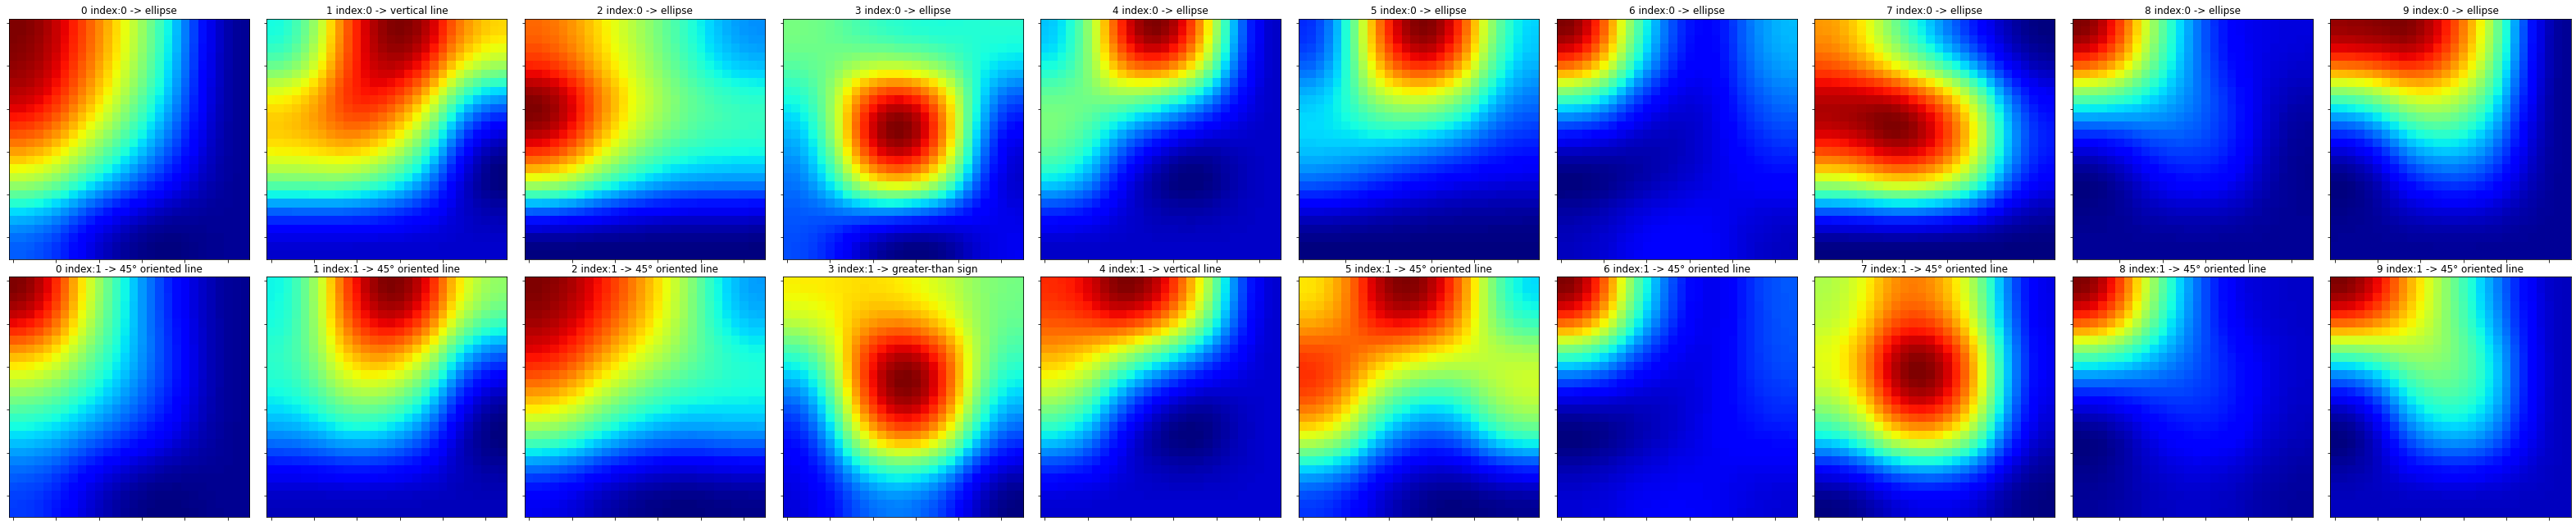

In [140]:
image_idx = 0
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111, nrows_ncols=(2, mnist_num_classes), axes_pad=0.3, label_mode="1", direction='column')

for category in range(mnist_num_classes):
  heightmap = np.zeros((3, 3))
  geo_category = descriptions[category]
  index = 0
  
  for geo_cat in sorted(geo_category, key=lambda k: len(geo_category[k]), reverse=True):
    title = f"{category} index:{index} -> {dataset_labels[geo_cat]}"

    for grid_position in geo_category[geo_cat]:
      heightmap[grid_position] += 1
    
    heigthmap = get_heatmap(heightmap, mnist_shape, True)
    show_image(heigthmap, mnist_shape, title, ax=grid[image_idx], cmap='jet')
    image_idx += 1

    if index < 1: 
      index += 1
    else:
      break

plt.show()

## Visualizing

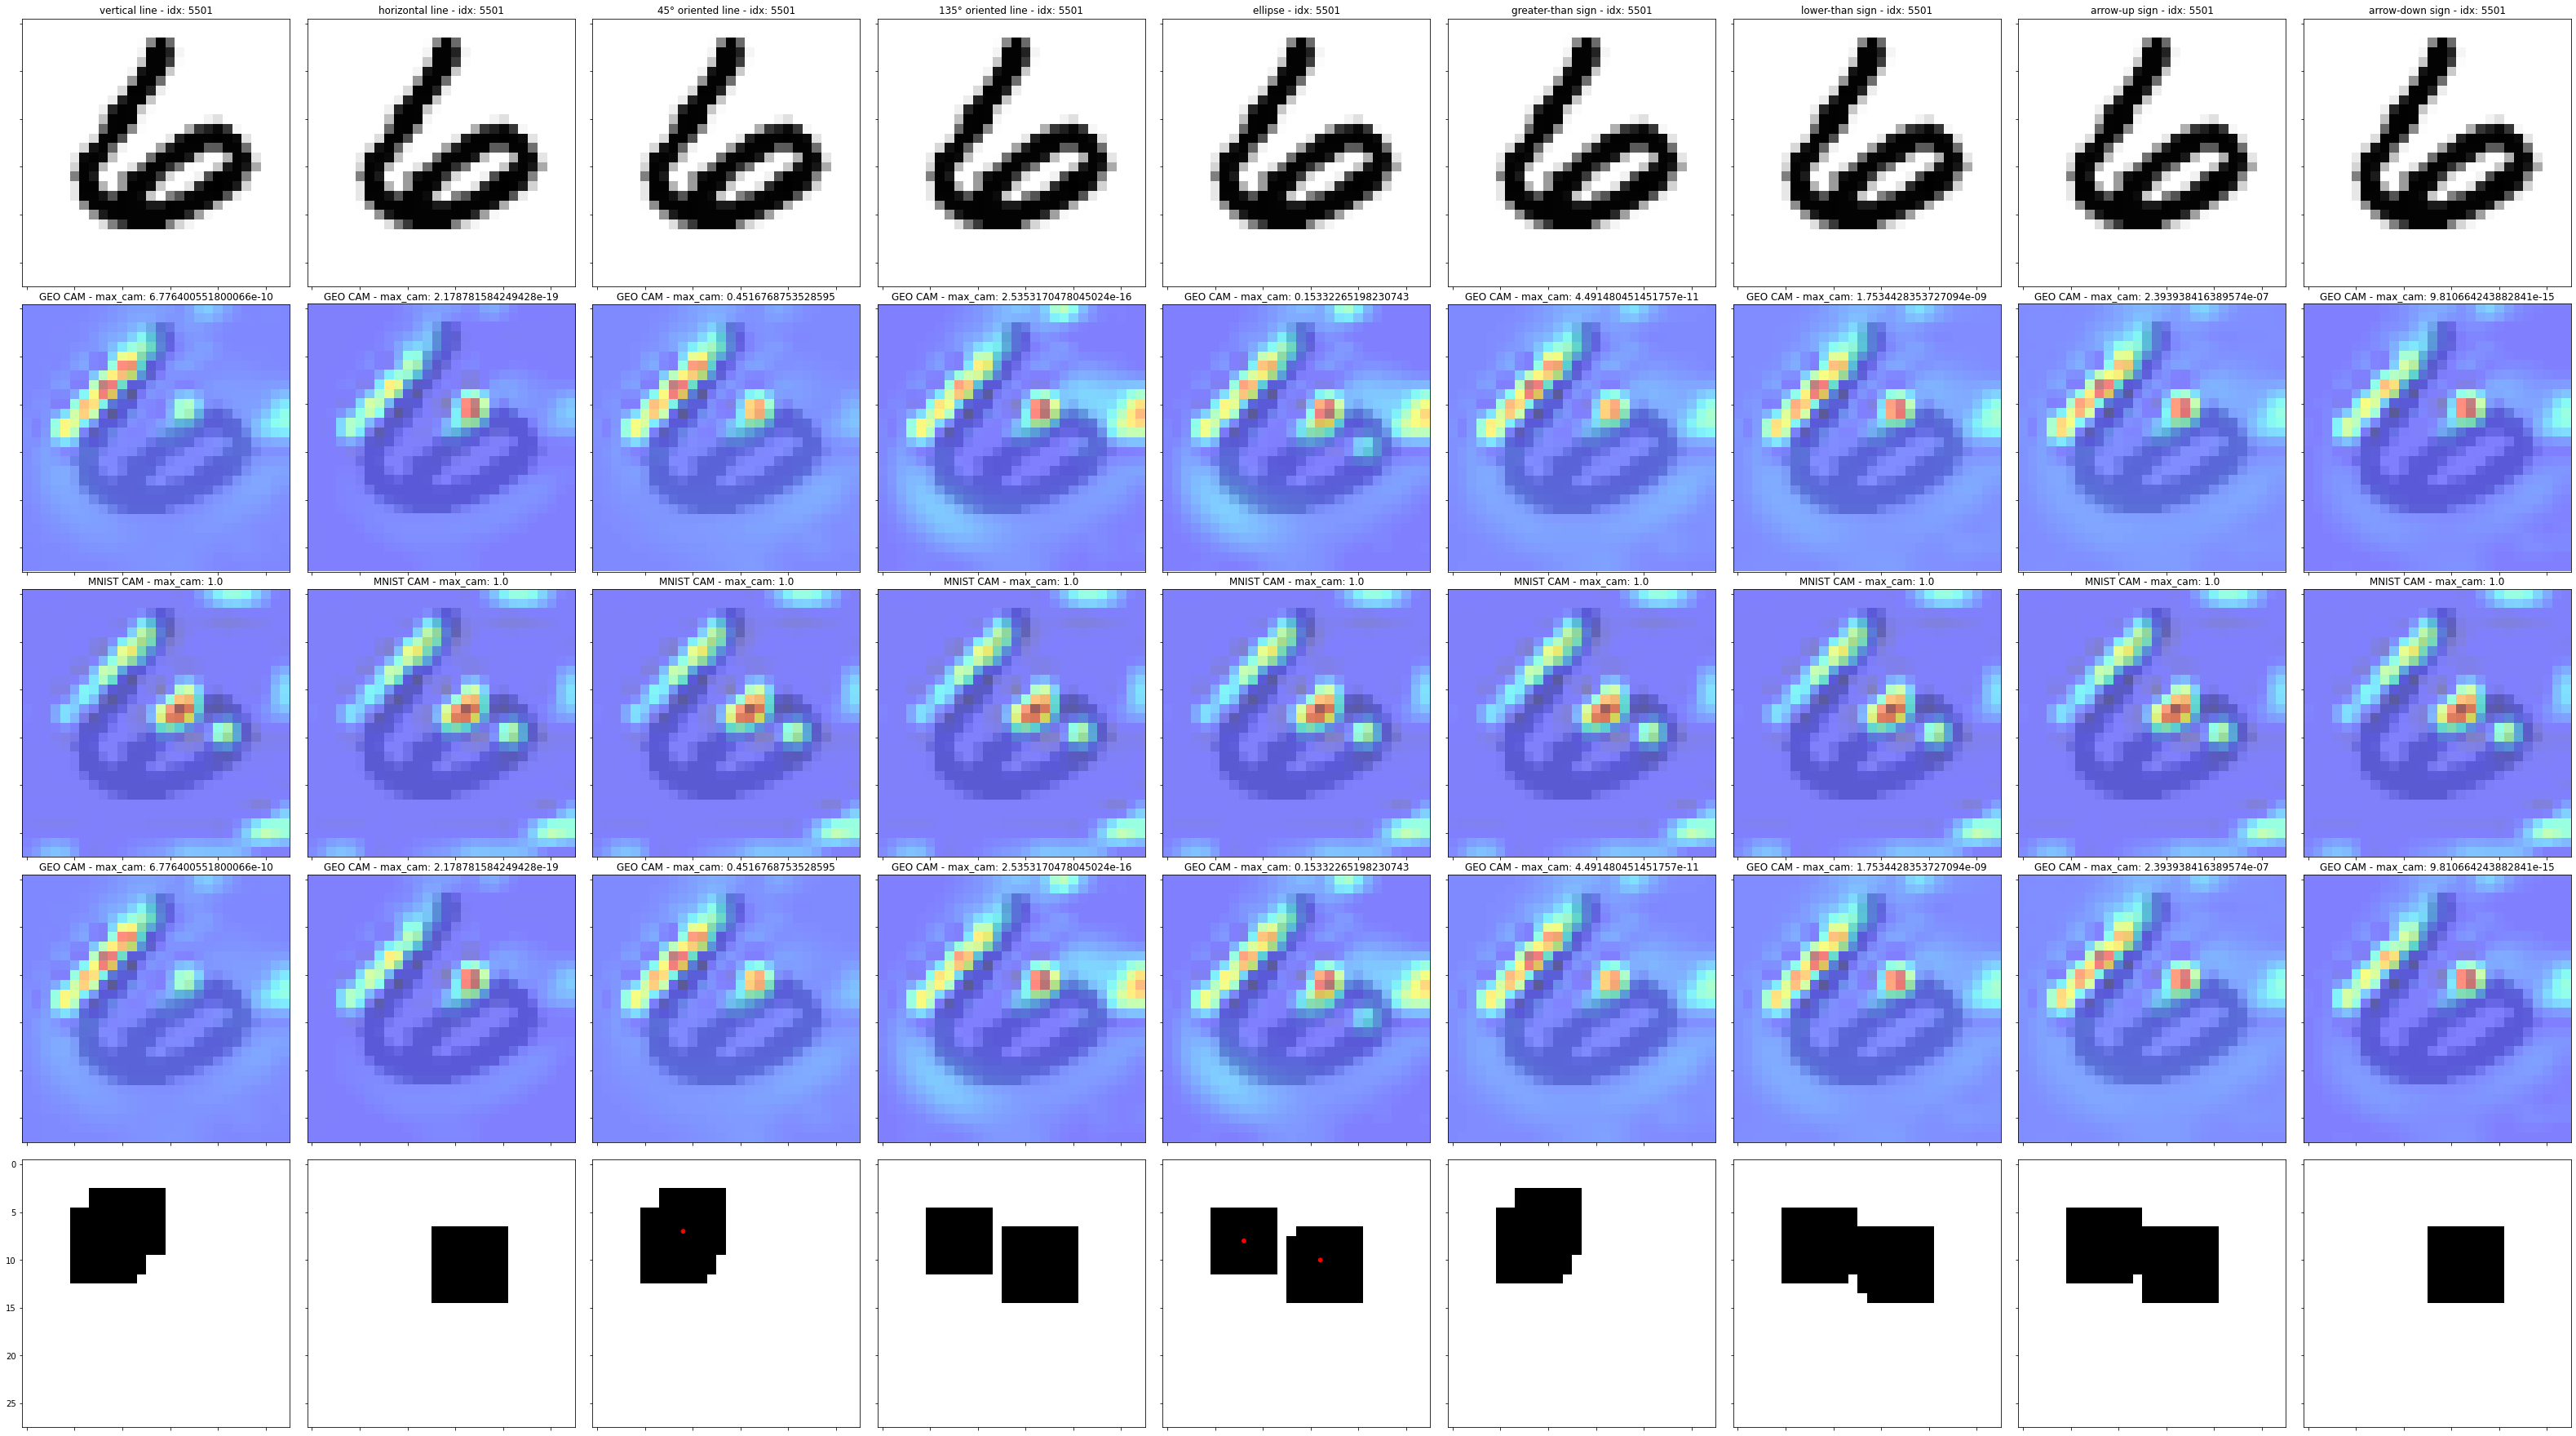

In [141]:
warnings.simplefilter('ignore', UserWarning)

# prediction based on conv output (5056, 6146, 2365, 2587, 5310, 6638, 1195) / 6222
test_image, test_label, test_idx = get_sample(mnist_test, 5501)
mnist_gcm_predictions = predict(model_gcm, test_image)
mnist_gcm_prediction = np.argmax(mnist_gcm_predictions)

assert test_label == mnist_gcm_prediction, "Missmatched ids. Wanted %d, received %d" % (test_label, mnist_gcm_prediction)

# start plotting
image_idx = 0
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111, nrows_ncols=(5, len(dataset_labels)), axes_pad=0.3, label_mode="1")

# images
for category in range(len(dataset_labels)):
  title = f"{dataset_labels[category]} - idx: {test_idx}"
  show_image(test_image, mnist_shape, title, ax=grid[image_idx])
  image_idx += 1

# geocam
cam_activations, cam_extra = get_experiment_cam_predictions_short(test_image, experiment_settings)

# geo cam
for category in range(len(dataset_labels)):
  cam = cam_extra['geo_cams'][category]
  title = f"GEO CAM - max_cam: {np.max(cam)}"
  show_heatmap(test_image, cam, mnist_shape, True, title, ax=grid[image_idx])
  image_idx += 1

# minist cam
cam = cam_extra['pd_cam']
for category in range(len(dataset_labels)):
  title = f"MNIST CAM - max_cam: {np.max(cam)}"
  show_heatmap(test_image, cam, mnist_shape, True, title, ax=grid[image_idx])
  image_idx += 1

# geocam cam
for category in range(len(dataset_labels)):
  cam = cam_activations[category]
  title = f"GEO CAM - max_cam: {np.max(cam)}"
  show_heatmap(test_image, cam, mnist_shape, True, title, ax=grid[image_idx])
  image_idx += 1

# geocam areas
for category in range(len(dataset_labels)):
  camt = cam_extra['thresholds'][category]
  grid[image_idx].imshow(camt, cmap='Greys')

  camp = cam_extra['centers'][category]
  for center_idx in range(len(camp)):
    camp_center = camp[center_idx]
    grid[image_idx].add_patch(plt.Circle(camp_center, 0.2, color='r'))

  image_idx += 1

plt.show()

## Adhoc Explanation

total order: [2 4 7 0 5 6 3 8 1]


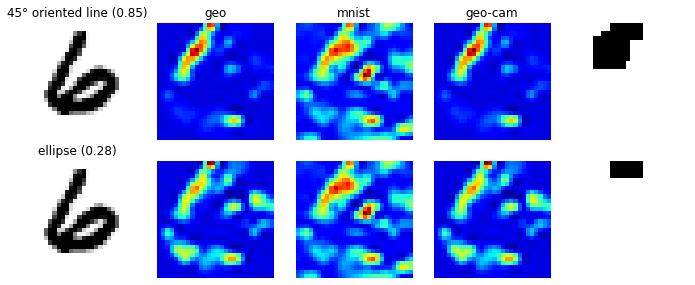

The number 6 can be explained by having a(n) 45° oriented line on the left-top and a(n) ellipse on the left-top.


In [142]:
test_image, test_label, test_idx = get_sample(mnist_test)

cam, extras = get_experiment_cam_predictions_short(test_image, experiment_settings)

first_pred = extras['order'][0]
sec_pred = extras['order'][1]

print(f"total order: {extras['order']}")

show_image_in_grid(np.array([
                             [
                              {'img': test_image, 'cmap':'Greys', 'title':f"{dataset_labels[first_pred]} ({extras['maxes'][first_pred]:.2f})"},
                              {'img': extras['geo_cams'][first_pred], 'cmap':'jet', 'title':'geo'},
                              {'img': extras['pd_cam'], 'cmap':'jet', 'title':'mnist'},
                              {'img': cam[first_pred], 'cmap':'jet', 'title':'geo-cam'},
                              extras['thresholds'][first_pred],
                              ],
                             [
                              {'img': test_image, 'cmap':'Greys', 'title':f"{dataset_labels[sec_pred]} ({extras['maxes'][sec_pred]:.2f})"},
                              {'img': extras['geo_cams'][sec_pred], 'cmap':'jet'},
                              {'img': extras['pd_cam'], 'cmap':'jet'},
                              {'img': cam[sec_pred], 'cmap':'jet'},
                              extras['thresholds'][sec_pred],
                              ]
                             ]), mnist_shape, figsize=(12, 12))

explanation = ""

for idx in range(2):
  order = extras['order'][idx]
  verbose_key = dataset_labels[order]

  grid_positions = extras['grid_pos'][order]

  if len(grid_positions) > 0:
    if len(explanation) > 0:
      explanation += " and"
    explanation += f" a(n) {verbose_key} on the"

  for grid_position in grid_positions:
    verbose_grid_pos = get_verbose_grid_position(*grid_position)
    explanation += f" {verbose_grid_pos[0]}-{verbose_grid_pos[1]}"

print(f"The number {extras['predictions']} can be explained by having{explanation}.")

# Stop

In [143]:
raise Exception('do not run any further')

Exception: ignored

# Archive

In [ ]:
def get_cam_predictions(test_image, model, classes, cam_method=grad_cam_m, threshold=180):
  cam_predictions = dict()
  cam_activations = dict()
  cam_thresholds = dict()
  min_cam_activation, max_cam_activation = 0, 0

  for category in range(classes):
    cam, _, _, _ = cam_method(test_image, model, category, 1)
    cam_activations[category] = cam
    min, max = np.min(cam), np.max(cam)
    min_cam_activation = np.minimum(min, min_cam_activation)
    max_cam_activation = np.maximum(max, max_cam_activation)

  for category in range(classes):
    cam = cam_activations[category]
    perc = safe_divide(cam - min_cam_activation, max_cam_activation - min_cam_activation, abs=False)
    
    cam = resize_image(perc, mnist_shape) * 255
    _, cam = cv2.threshold(cam, threshold, 255, cv2.THRESH_BINARY)
    cam_thresholds[category] = cam
    cv_img = np.array(cam, dtype = np.uint8)
    contours, _ = cv2.findContours(cv_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cam_predictions[category] = (np.max(perc), [])

    for i in range(len(contours)):
      moments = cv2.moments(contours[i])
      if moments['m00'] > 0:
        center = (safe_divide(moments['m10'], moments['m00']), safe_divide(moments['m01'], moments['m00']))
        cam_predictions[category][1].append(center)
  
  return cam_activations, cam_thresholds, cam_predictions

In [ ]:
# Predictions
_, predictions = model_gcmcam(np.expand_dims(test_image, 0))
sorted_indexes = np.flip(np.argsort(predictions[1][0]))
percentages = np.round(predictions[1][0] / predictions[1][0][sorted_indexes[0]], 5)

print(f"1st : {dataset_labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {dataset_labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {dataset_labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

In [ ]:
# verifying transfer learning
print(f"geo conv weights: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm1 conv weights: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm2 conv weights: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")

print(f"geo conv biases: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm1 conv biases: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm2 conv biases: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")

test_image, test_label, test_idx = get_sample(mnist_test)
test_geo = Model([model_geo.inputs], [get_layer(model_geo, 'geo_last_conv').get_output_at(0), model_geo.output])
test_gcm = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'geo_last_conv').get_output_at(1), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])
test_gcm_ = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'gcm_mnist_first_conv').get_output_at(0), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])

print(f"geo conv activations: {hashlib.sha256(test_geo(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm conv activations: {hashlib.sha256(test_gcm(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm alterate conv activations: {hashlib.sha256(test_gcm_(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")

In [ ]:
# debugging cams and values
test_ids = {
        "1": 3455,
        "4": 6195,
        "0": 3710,
        "6": 6187,
        "7": 6606,
        "5": 6148,
        "9": 5622,
    }

test_idx = 6
test_mnist_idx = test_ids[f"{test_idx}"]
test_mnist_image = mnist_test[0][test_mnist_idx]
# show_image(test_mnist_image)

# GCM (Transfer learned network - init geo, end mnist)
# gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_idx)
# gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_mnist_image, model_gcm, -3)
print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")

title = f"MNIST prediction: {gcm_mnist_prediction} (truth: {test_idx})"
show_heatmap(test_mnist_image, gcm_mnist_cam, mnist_shape, True, title)

assert test_idx == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, gcm_mnist_prediction)

In [ ]:
# 1) prediction based on conv output
test_image, test_label = get_sample(mnist_test)

cam_layer = get_cam_layer(model_gcm, "conv2d_5")
cam_model = Model([model_gcm.inputs], [cam_layer.get_output_at(1), model_gcm.output])
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp_m(test_image, cam_model)
# print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")
assert test_label == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, test_label)

# Prediction
gcg_predictions = model_geo_2.predict(gcm_conv_output)
sorted_indexes = np.flip(np.argsort(gcg_predictions[0]))
percentages = gcg_predictions[0] / gcg_predictions[0][sorted_indexes[0]]

print(f"1st : {dataset_labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {dataset_labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {dataset_labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

# Debug (CAM projection)
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, sorted_indexes[0])
show_heatmap(test_image, gcg_mnist_cam, mnist_shape, True)

In [ ]:
# 2) prediction based on cam heatmap (SHOULD NOT WORK)

test_image, test_label = get_sample(mnist_test, 6187)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_image, model_gcm)
heatmap = get_heatmap(gcm_mnist_cam, mnist_shape).reshape(*mnist_shape, 1) * 255
prediction = predict(model_geo, heatmap)

show_image(heatmap)

sorted_indexes = np.flip(np.argsort(prediction[0]))
percentages = prediction[0] / prediction[0][sorted_indexes[0]]

print(f"1st : {dataset_labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {dataset_labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {dataset_labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

plt.figure(facecolor='white')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(test_image.reshape(*mnist_shape), alpha=0.5, cmap='Greys')
plt.imshow(heatmap.reshape(*mnist_shape), cmap='jet', alpha=0.5)
plt.show()  

In [ ]:
test_image, test_label, test_idx = get_sample(mnist_test)

# geo2 (sliced) model (from model_gcm - transfer learning) for cam prediction
model_geocam = Model([model_geo.inputs], [get_layer(model_geo, "geo_last_conv").get_output_at(0), model_geo.output])

model_gcmcam_1 = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "mnist_last_conv").get_output_at(0), 
                      model_gcm_complete.output])

model_gcmcam = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "geo_last_conv").get_output_at(0), 
                      model_gcm_complete.output])

cam_threshold = 0.7
cam_method = grad_cam_m

def get_maskedcam_predictions(test_image, classes, cam_method=grad_cam_m, threshold=0.8):  
  centers = dict()
  grid_pos = dict()
  geo_cam = dict()
  masked_geo_cam = dict()
  masked_geo_thresh = dict()

  geo_cam_maxes = []
  masked_geo_cam_maxes = []

  test_image_bb = get_boundingbox(test_image)

  # minist cam mask
  cam, _, mnist_predictions, _ = cam_method(test_image, model_gcmcam_1)
  _, _, cam = normalize_cam(cam)
  mnist_cam = np.copy(cam)

  # geo branch
  for category in range(classes):
    cam = cam_method(test_image, model_geocam, category)[0]
    # print(cam)
    min, max, cam = normalize_cam(cam)

    geo_cam[category] = np.copy(cam)
    geo_cam_maxes.append(max)

  # mask (geo - mnist)
  for category in range(classes):
    modulation = safe_divide(geo_cam_maxes[category], np.max(geo_cam_maxes), abs=False) # modulation
    cam = geo_cam[category] - (geo_cam[category] * (1 - mnist_cam)) # mask
    # cam = cam * modulation
    # print(f"min: {np.min(cam)}, max: {np.max(cam)}")
    masked_geo_cam_maxes.append(np.max(cam) * modulation)
    masked_geo_cam[category] = np.copy(cam)

  # threshorld and centers
  for category in range(classes):
    cam = masked_geo_cam[category]
    # cam = (cam >= threshold) * threshold
    cam = resize_image(cam, mnist_shape)

    _, cam = cv2.threshold(cam, np.max(cam) * threshold, np.max(cam), cv2.THRESH_BINARY)
    
    masked_geo_thresh[category] = cam

    cv_img = np.array(cam * 255, dtype = np.uint8)
    contours, _ = cv2.findContours(cv_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    centers[category] = []
    grid_pos[category] = set()

    for i in range(len(contours)):
      moments = cv2.moments(contours[i])
      if moments['m00'] > 0:
        center = (safe_divide(moments['m10'], moments['m00']), safe_divide(moments['m01'], moments['m00']))
        grid_position = get_grid_position(center, mnist_shape, boundingbox=test_image_bb)
        
        centers[category].append(center)
        grid_pos[category].add(grid_position)
  
  extra_infos = dict()
  extra_infos['order'] = np.flip(np.argsort(masked_geo_cam_maxes), 0)
  extra_infos['maxes'] = masked_geo_cam_maxes
  extra_infos['thresholds'] = masked_geo_thresh
  extra_infos['geo_cams'] = geo_cam
  extra_infos['mnist_cam'] = mnist_cam
  extra_infos['mnist_pred'] = np.argmax(mnist_predictions)
  extra_infos['centers'] = centers
  extra_infos['grid_pos'] = grid_pos

  return masked_geo_cam, extra_infos

# cam, extras = get_maskedcam_predictions(test_image, len(dataset_labels))

# first_pred = extras['order'][0]

# print(f"first: {dataset_labels[first_pred]} - total order: {extras['order']}")
# print(extras['grid_pos'][first_pred])

# show_image_in_grid(np.array([
#                              [
#                               test_image, 
#                               {'img': extras['geo_cams'][first_pred], 'cmap':'jet', 'title':'geo'},
#                               {'img': extras['mnist_cam'], 'cmap':'jet', 'title':'mnist'},
#                               {'img': cam[first_pred], 'cmap':'jet', 'title':'geo-cam'},
#                               extras['thresholds'][first_pred],
#                               ]
#                              ]), mnist_shape)